In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import SVG
import sknetwork as skn
from sklearn.metrics import adjusted_mutual_info_score as AMI


# Toy Dataset

The graph represents links between 30 wikipedia pages, 10 each from topics: science, art or philosophy.
There is a feature vector for each page, each feture representing a keyword count.

* `A`: csr adjacency matrix, directed (30 nodes)
* `names`: name of each node (wikipedia page); we also define `names_dict` for quick reference
* `features`: csr matrix of binary features
* `name_features`: name of each feature (11 keywords)
* `labels`: numpy array, node label (0, 1 or 2)
* `name_labels`: name of the labels (category of page: science, art or philosophy)


In [2]:
from sknetwork.data import art_philo_science

graph = art_philo_science(metadata=True)
A = graph.adjacency
features = graph.biadjacency
names = graph.names
names_dict = {v:k for k,v in enumerate(names)}
names_features = graph.names_col
names_labels = graph.names_labels
labels = graph.labels
layout = graph.position


## Visualization - directed graph and features

In [3]:
from sknetwork.embedding import Spring, SVD
from sknetwork.visualization import svg_graph, svg_bigraph

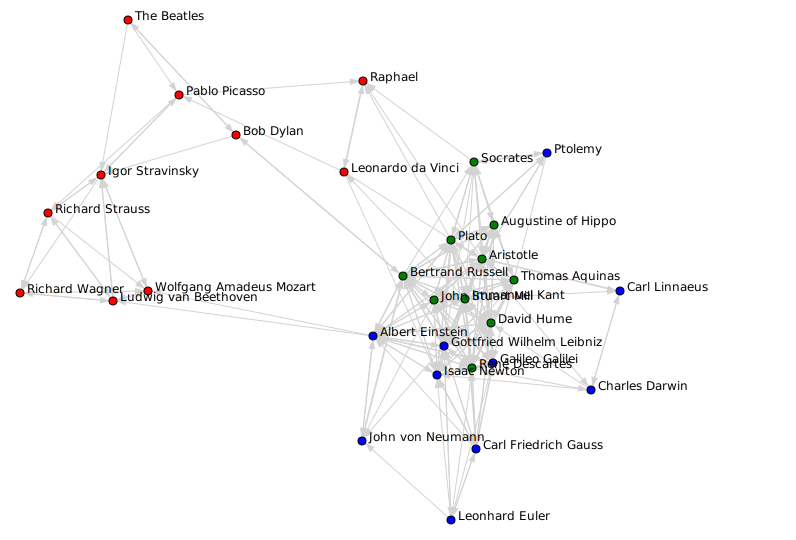

In [4]:
layout = Spring(2, position_init='spectral').fit_transform(A)
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=labels,
                  node_size=4, edge_color='lightgray')
SVG(image)

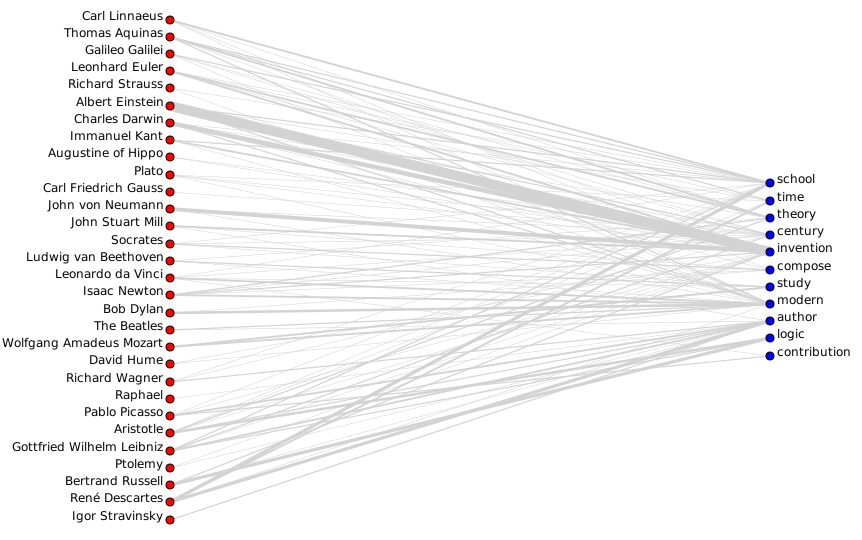

In [5]:
image = svg_bigraph(features, names_row=names, names_col=names_features, width=600, height=500, 
                    color_row='red', color_col='blue', node_size=4, edge_color='lightgray')
SVG(image)


## EDA -- centrality

In [6]:
from sknetwork.ranking import PageRank, Betweenness, HITS
from sknetwork.utils import get_degrees, get_weights


In [7]:
## in/out degree, total degree
out_deg = get_degrees(A)
in_deg = get_degrees(A, transpose=True)
deg = out_deg + in_deg
top_deg = deg.argsort()[::-1]

## top total degree nodes
print(names[top_deg[:3]])


['Aristotle' 'Bertrand Russell' 'Immanuel Kant']


In [8]:
## top PageRank 
pagerank = PageRank()
top_pr = pagerank.fit_predict(A).argsort()[::-1]
print(names[top_pr[:3]])


['Ludwig van Beethoven' 'Wolfgang Amadeus Mozart' 'Aristotle']


In [9]:
## top Betweenness 
between = Betweenness()
top_bet = between.fit_predict(A).argsort()[::-1]
print(names[top_bet[:3]])


['Leonardo da Vinci' 'Aristotle' 'Raphael']


In [10]:
## personalized PageRank - top nodes given 1+ seed nodes
seeds = {'Aristotle','Socrates'}
indices = [k for k,v in enumerate(names) if v in seeds]
weights = {x:1 for x in indices}
top_ppr = pagerank.fit_predict(A, weights).argsort()[::-1]
print(names[top_ppr[:5]])


['Aristotle' 'Socrates' 'Plato' 'Augustine of Hippo' 'Isaac Newton']


In [11]:
## top hub/authority scores
hits = HITS()
top_hub = hits.fit_predict(A).argsort()[::-1]
top_auth = hits.fit_predict(A.transpose()).argsort()[::-1]
print('top hub:',names[top_hub[:3]])
print('top authority:',names[top_auth[:3]])


top hub: ['Immanuel Kant' 'Aristotle' 'David Hume']
top authority: ['René Descartes' 'Aristotle' 'David Hume']


## Shortest paths

We look at the number of hops in the shortest path, either **from** source node(s) or **to** destination node(s).

We also look at the undirected version.


In [12]:
from sknetwork.path import get_distances, get_shortest_path
from sknetwork.utils import directed2undirected


In [13]:
## path length FROM the source
seed = 'Leonhard Euler'
source = np.where(names==seed)[0][0]
distances = get_distances(A, source)
print(Counter(distances))
## which nodes are furthest away
print('furthest nodes:',names[distances == max(distances)])

Counter({2: 11, 3: 7, 1: 6, 4: 5, 0: 1})
furthest nodes: ['Richard Wagner' 'Igor Stravinsky' 'The Beatles' 'Richard Strauss'
 'Pablo Picasso']


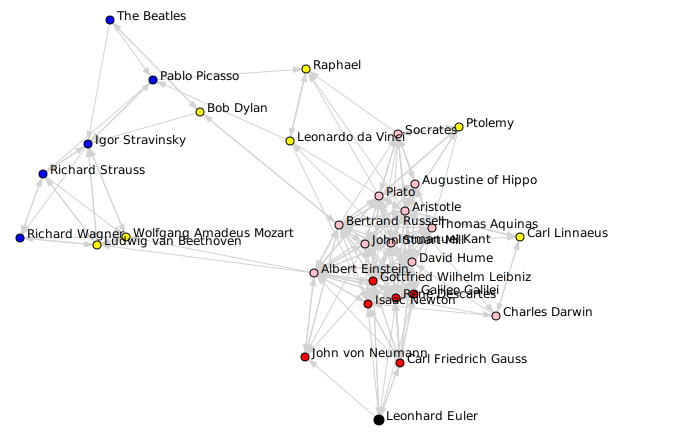

In [14]:
## color w.r.t. distance from seed node
image = svg_graph(A, names=names, position=layout, width=500, height=400, seeds=source,
                  labels=distances, node_size=4, node_order = np.argsort(-distances),
                  label_colors=['black','red','pink','yellow','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [15]:
## path length TO the destination
seed = 'Leonhard Euler'
dest = np.where(names==seed)[0][0]
distances = get_distances(A.transpose(), dest)
print(Counter(distances))
## which nodes are furthest away
print('furthest nodes:',names[distances >= max(distances)-1])

Counter({2: 12, 3: 7, 7: 3, 1: 2, 4: 2, 0: 1, 8: 1, 6: 1, 5: 1})
furthest nodes: ['Richard Wagner' 'Ludwig van Beethoven' 'Wolfgang Amadeus Mozart'
 'Richard Strauss']


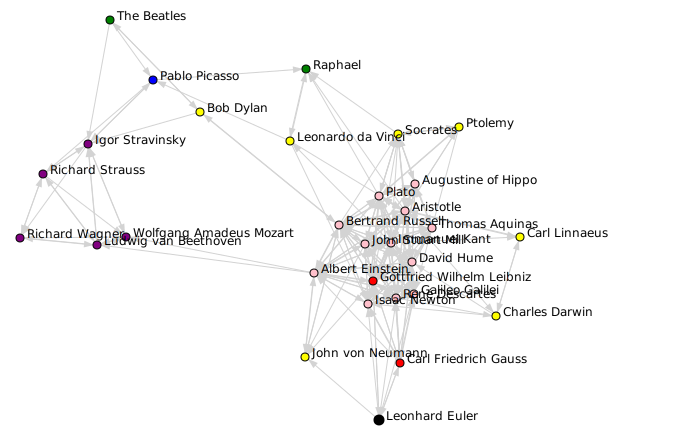

In [16]:
## color w.r.t. distance to seed node
image = svg_graph(A, names=names, position=layout, width=500, height=400, seeds=dest,
                  labels=distances, node_size=4, node_order = np.argsort(-distances),
                  label_colors=['black','red','pink','yellow','green','blue','purple','purple','purple'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


## Clustering


In [17]:
from sknetwork.clustering import Louvain
 

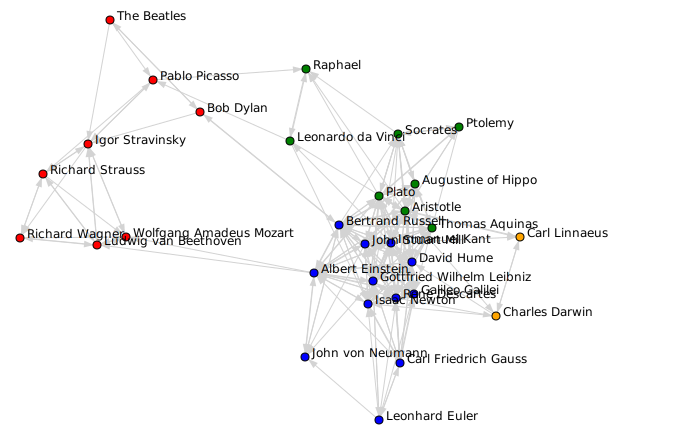

In [18]:
louvain = Louvain(shuffle_nodes=True, resolution=1.0)
labels_pred = louvain.fit_predict(A)
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=labels_pred, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [19]:
AMI(labels,labels_pred)

0.44245857575533404

### igraph - several other clustering algorithms

In [20]:
import igraph as ig
import partition_igraph

In [21]:
## igraph graph given adjacency
A_und = directed2undirected(A)
g = ig.Graph.Adjacency(A_und, 'undirected')

## run a few other clustering algorithms
ecg = g.community_ecg(final='leiden', ens_size=20, refuse_score=True)
ecg_class = ecg.membership
infomap_class = g.community_infomap().membership
leiden_class = g.community_leiden(objective_function='modularity').membership


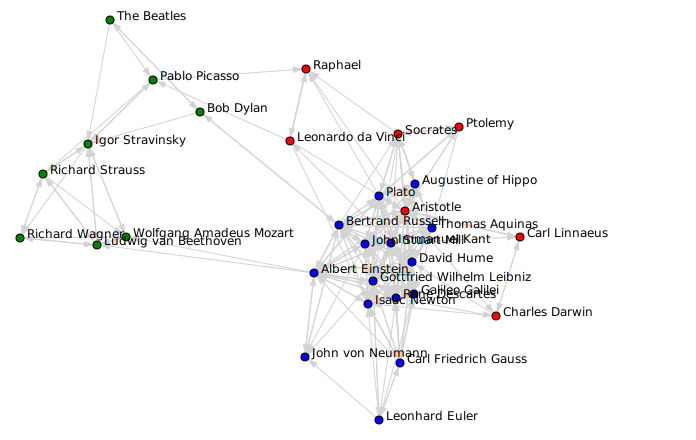

In [22]:
## Leiden
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=leiden_class, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)


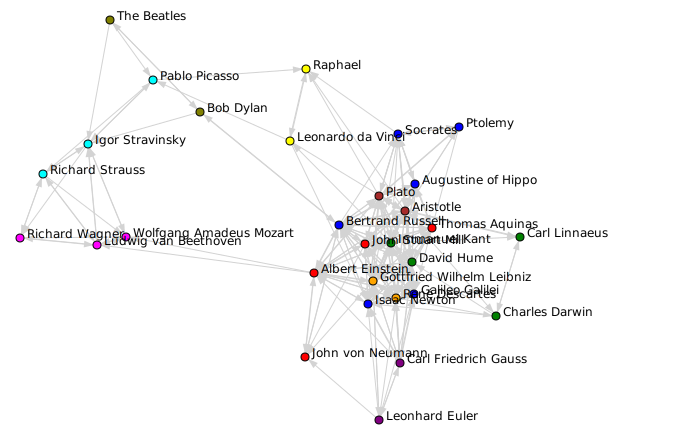

In [23]:
## infomap
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=infomap_class, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)


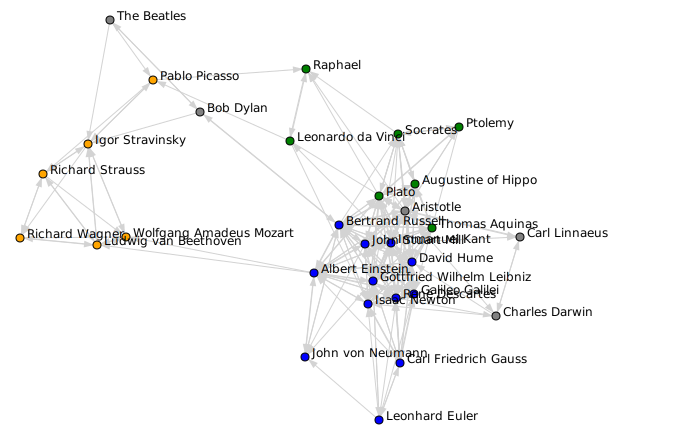

In [24]:
## ECG with 'refuse to cluster' option
ecg_refuse = np.array(ecg_class)
ecg_refuse[np.array(ecg.refuse_overall) > .67] = -1
ctr = Counter(ecg_refuse)
drop = [k for k in ctr.keys() if k>=0 and ctr[k]<=2]
for d in drop:
    ecg_refuse[ecg_refuse==d]=-1
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=ecg_refuse, node_size=4, edge_color='lightgray', display_edge_weight=False)
SVG(image)

## Semi-supervised learning

In [25]:
from sknetwork.classification import PageRankClassifier, get_accuracy_score

In [26]:
## fix (correct) labels for a few seed nodes, and learn the other labels
seeds = ['Socrates', 'Thomas Aquinas', 'Galileo Galilei', 'Leonhard Euler',
         'Richard Strauss', 'The Beatles']
labels_ssl = {names_dict[x]:labels[names_dict[x]] for x in seeds}

## classifier
pr = PageRankClassifier()
labels_pred = pr.fit_predict(A, labels_ssl)
print('accuracy:',get_accuracy_score(labels, labels_pred))

accuracy: 0.6666666666666666


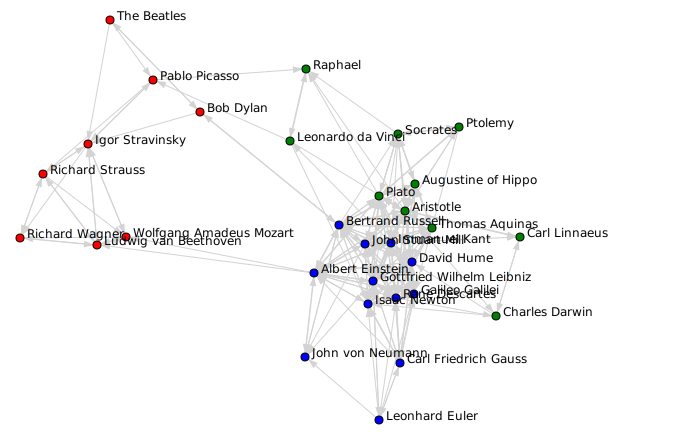

In [27]:
image = svg_graph(A, names=names, position=layout, width=500, height=400, 
                  labels=labels_pred, node_size=4, edge_color='lightgray', 
                  display_edge_weight=False)
SVG(image)

In [28]:
from ipywidgets import interact
import cairosvg
from PIL import Image
from io import BytesIO


In [29]:
def plot_ssl(threshold=0.5):
    labs = labels_pred.copy()
    proba = np.max(pr.predict_proba(),axis=1)
    labs[proba <= threshold] = -1
    image = svg_graph(A, position=layout, width=500, height=400, 
                      labels=labs, node_size=5, edge_color='lightgray', 
                      display_edge_weight=False)
    img_png = cairosvg.svg2png(image, dpi=600, scale=3)
    img = Image.open(BytesIO(img_png))
    plt.figure(figsize = (8,6))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

In [30]:
interactive_plot = interact(plot_ssl, threshold=(0,1,.02));
interactive_plot;

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [31]:
sdfasf()

NameError: name 'sdfasf' is not defined

## GNN -- classification


In [ ]:
from scipy.sparse import hstack
from sknetwork.gnn import GNNClassifier as GNN


In [ ]:
# Training set
labels_train = labels.copy()
train_mask = np.random.random(size=len(labels_train)) < 0.3 ## keep 30% for testing
labels_train[train_mask] = -1 ## negative labels are ignored in training


In [ ]:
# GNN classifier with a single hidden layer
hidden_dim = 5
n_labels = 3

gnn = GNN(dims=[hidden_dim, n_labels],
                layer_types='Conv',
                activations='ReLu',
                verbose=True)

## for node features, we try: the unweighted adjacency matrix
node_features = hstack((A,features))
gnn_pred = gnn.fit_predict(A, node_features, labels=labels_train, 
                           n_epochs=100, random_state=42, history=True)


In [ ]:
## test set accuracy
get_accuracy_score(labels[train_mask], gnn_pred[train_mask])


In [ ]:
svd = SVD(2)
emb = svd.fit_transform(node_features)
image = svg_graph(A, names=names, position=emb, width=600, height=500, labels=labels,
                  node_size=4, edge_color='lightgray')
SVG(image)



## undirected

In [ ]:
from sknetwork.utils import directed2undirected
from sknetwork.topology import get_core_decomposition as coreness
A_und = directed2undirected(A)
core = coreness(A_und)

In [ ]:
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=(core==max(core)),
                  node_size=4, edge_color='lightgray')
SVG(image)


### triangles

In [ ]:
from sknetwork.topology import count_triangles, get_clustering_coefficient, count_cliques


In [ ]:
print(count_triangles(A_und), count_cliques(A_und, clique_size=3),
      count_cliques(A_und, clique_size=10), get_clustering_coefficient(A_und))


## scalable?

trying Louvain on 1M nodes

In [75]:
%%time
ABCD = skn.data.from_csv('edge.dat', sep='\t', directed=False)
ABCD_ml = Louvain()
comm_ml = ABCD_ml.fit_predict(ABCD.adjacency)

CPU times: user 17 s, sys: 1.17 s, total: 18.2 s
Wall time: 18.2 s


In [79]:
comm = pd.read_csv('com.dat', sep='\t', header=None)[1]
AMI(comm, comm_ml)

0.998669350241395

In [83]:
%%time
G = ig.Graph.Read_Ncol('edge.dat', directed=False)
G.vs['ml']= G.community_multilevel().membership


CPU times: user 30.9 s, sys: 442 ms, total: 31.3 s
Wall time: 31.3 s


In [85]:
G.vs['gt'] = [comm[int(i)-1] for i in G.vs['name']]
AMI(G.vs['gt'],G.vs['ml'])

0.9989040442441338